In [20]:
import numpy as np
import matplotlib.pyplot as plt
from radialmaze.environments import RadialMaze
from tqdm.notebook import tqdm

from stable_baselines3 import A2C, PPO, DQN
import gymnasium as gym
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

In [21]:
N_ARMS = 5
ARM_WIDTH = 0.2
ARM_DISCRETIZATION = 100
all_arms_rewarded = [ (i, 0.9) for i in range(N_ARMS)] 
random_scatter = lambda : [ (i, 0.4+(1-0.4)*(np.random.rand())) for i in np.random.choice(N_ARMS, N_ARMS*5, replace=True)]
show_properties = True

maze_args = {
    'N_arms': N_ARMS,
    'arm_width': ARM_WIDTH,
    'arm_discretization': ARM_DISCRETIZATION,
    'animal_params': {
        'max_velocity': 0.05,
        'persistence': 0.5,
        'cost_of_exertion': 1,
        'benefit_of_food': 10,
        'benefit_of_exploration': 2,
        'exploratory_decay_time': 5,
        'cost_of_hitting_wall': 5,
    },
    'experiment_params' : {
        'reward_list': all_arms_rewarded,
    }
}

In [22]:
# create the environment
maze = RadialMaze(**maze_args)

# check the environment
check_env(maze)

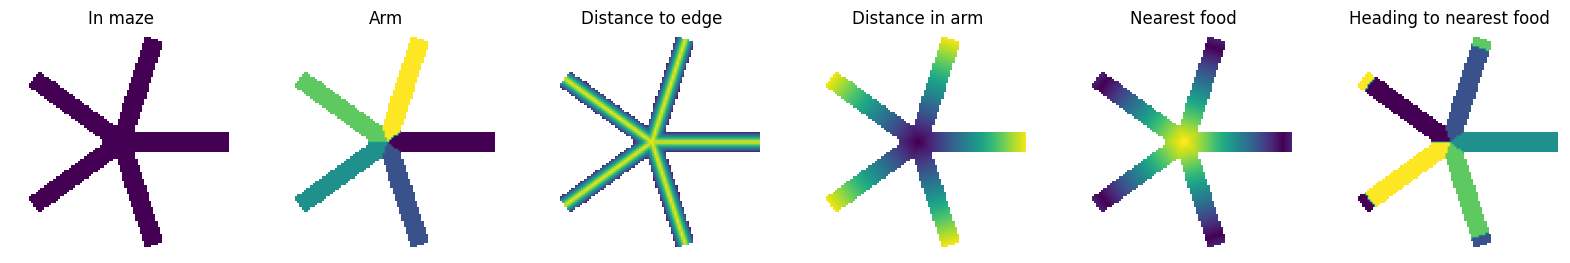

In [23]:
# plot maze
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

INMAZE = np.zeros(X.shape)*np.nan
DISTANCE_TO_EDGE = np.zeros(X.shape)
DISTANCE_IN_ARM = np.zeros(X.shape)
ARM = np.zeros(X.shape)
NEAREST_FOOD = np.zeros(X.shape)
HEADING_NEAREST_FOOD = np.zeros(X.shape)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        in_maze,arm,distance_to_edge,distance_in_arm = maze.in_maze(X[i,j],Y[i,j])
        nearest_food, heading_to_nearest_food = maze.nearest_food(X[i,j],Y[i,j],return_direction=True)
        INMAZE[i, j] = in_maze if in_maze else np.nan
        ARM[i, j] = (arm+1) * INMAZE[i,j]
        DISTANCE_TO_EDGE[i, j] = distance_to_edge * INMAZE[i,j]
        DISTANCE_IN_ARM[i, j] = distance_in_arm * INMAZE[i,j]
        NEAREST_FOOD[i, j] = nearest_food * INMAZE[i,j]
        HEADING_NEAREST_FOOD[i, j] = heading_to_nearest_food * INMAZE[i,j]

if show_properties:
    fig, ax = plt.subplots(1, 6, figsize=(5*4, 4))
    ax[0].imshow(INMAZE, extent=[-1, 1, -1, 1])
    ax[0].set_title('In maze')
    ax[0].axis('off')
    ax[1].imshow(ARM, extent=[-1, 1, -1, 1])
    ax[1].set_title('Arm')
    ax[1].axis('off')
    ax[2].imshow(DISTANCE_TO_EDGE, extent=[-1, 1, -1, 1])
    ax[2].set_title('Distance to edge')
    ax[2].axis('off')
    ax[3].imshow(DISTANCE_IN_ARM, extent=[-1, 1, -1, 1])
    ax[3].set_title('Distance in arm')
    ax[3].axis('off')
    ax[4].imshow(NEAREST_FOOD, extent=[-1, 1, -1, 1])
    ax[4].set_title('Nearest food')
    ax[4].axis('off')
    ax[5].imshow(HEADING_NEAREST_FOOD, extent=[-1, 1, -1, 1])
    ax[5].set_title('Heading to nearest food')
    ax[5].axis('off')
    plt.show()

In [24]:
def plot_trajectory(maze):
    OBS = np.array(maze.observation_history)
    REW = np.array(maze.reward_history)
    # plot the maze in black and white
    plt.figure()
    plt.imshow(np.nan_to_num(INMAZE), extent=[-1, 1, -1, 1], cmap='gray')
    # plot the trajectory
    plt.plot(OBS[:,0], OBS[:,1], 'k', linewidth=0.1, zorder=0)
    # plot the rewards and color it (+ve and -ve rewards are done separately)
    neg = plt.scatter(OBS[REW>0,0], OBS[REW>0,1], c=REW[REW>0], s=np.abs(REW[REW>0])*10, zorder=1, cmap='Greens', alpha=0.5, vmin=0, vmax=np.max(REW[REW>0]))
    pos = plt.scatter(OBS[REW<0,0], OBS[REW<0,1], c=REW[REW<0], s=np.abs(REW[REW<0])*10, zorder=1, cmap='Reds_r', alpha=0.5, vmin=np.min(REW[REW<0]), vmax=0)
    # plot two colorbars
    plt.colorbar(neg, label='Reward', shrink=0.8)
    plt.colorbar(pos, label='Punishment', shrink=0.8)
    plt.axis('off')
    plt.show()
    # plot the reward history
    plt.figure(figsize=(10, 2))
    plt.plot(REW)
    plt.xlim([0, len(REW)])
    plt.xlabel('Time')
    plt.ylabel('Reward')
    plt.box(False)
    # get a twin axis for distance from food
    ax2 = plt.gca().twinx()
    ax2.plot(OBS[:,-2], 'k', alpha=0.6)
    ax2.set_ylabel('Distance from\nnearest visible food')
    ax2.set_ylim([0, 2])
    plt.box(False)
    plt.show()


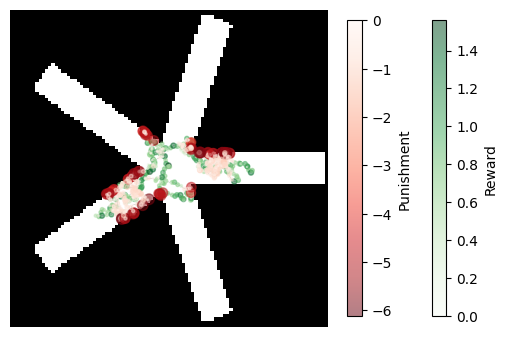

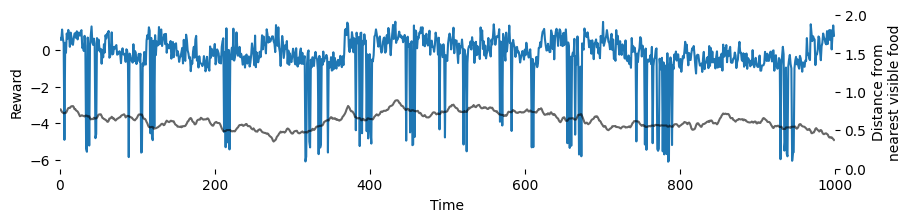

In [25]:
obs, info = maze.reset()
n_steps = 1000
for _ in range(n_steps):
    # Random action
    action = maze.action_space.sample()
    obs, reward, terminated, truncated, info = maze.step(action)
    if terminated:
        break

plot_trajectory(maze)

In [28]:
# make the environment vectorized
env = make_vec_env(RadialMaze, n_envs=20, env_kwargs=maze_args)

# Instantiate the agent
# model = A2C('MlpPolicy', env, verbose=1)
model = PPO('MlpPolicy', env, verbose=1)

# Train the agent and track the training progress
model.learn(total_timesteps=100000)

# save the model
# model.save("a2c_radialmaze")
model.save("ppo_radialmaze")
del model  # delete trained model to demonstrate loading
        

Using cpu device
------------------------------
| time/              |       |
|    fps             | 2302  |
|    iterations      | 1     |
|    time_elapsed    | 17    |
|    total_timesteps | 40960 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1140        |
|    iterations           | 2           |
|    time_elapsed         | 71          |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.019623226 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.71       |
|    explained_variance   | 0.0045      |
|    learning_rate        | 0.0003      |
|    loss                 | 41          |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00929    |
|    std                  | 0.933       |
|    value_loss           | 183         |
----------

In [17]:
# load the model
# model = A2C.load("a2c_radialmaze")
model = PPO.load("ppo_radialmaze")

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-50938.87 +/- 50.70


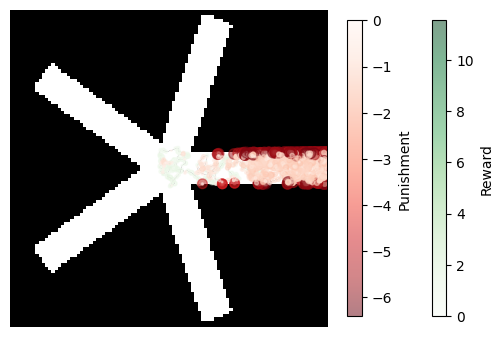

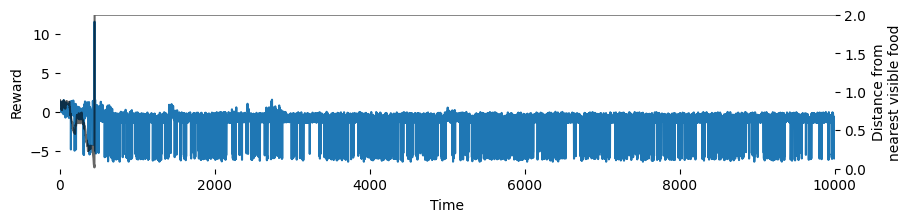

In [19]:
# load the model
# model = A2C.load("a2c_radialmaze")
model = PPO.load("ppo_radialmaze")

# test the model
obs, info = maze.reset()
n_steps = 10000
for _ in range(n_steps):
    action = model.predict(obs, deterministic=False)[0]
    obs, reward, terminated, truncated, info = maze.step(action)
    if terminated:
        break

plot_trajectory(maze)